In [1]:
# We will load some libraries again first

from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

#from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
#seed_everything(SEED)

In [3]:
# Set working directory
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
os.chdir('Machine Learning Model')

# We need to check whether the directory is there
try:
    os.mkdir('data')
except:
    print("Directory already exists")
os.chdir('data')

Directory already exists


Obtaining and cleaning data.

In [19]:
CHEMBLID = 'CHEMBL204' # Enter CHEMBL ID of target
FILENAME = 'CHEMBL204.csv.zip'

data = pd.read_csv(FILENAME, sep=';')

print("There are a total of {} datapoints in this set".format(len(data)))
data.head()

There are a total of 10620 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL273264,NAFAMOSTAT,3,347.38,0,2.65,1 (FUT-175),N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1128999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1996.0,None,NaN
1,CHEMBL116258,NaN,0,439.95,0,2.63,31,Cc1cnc(NCCc2ccccc2)c(=O)n1CC(=O)NCc1cc(Cl)ccc1CN,Ki,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1136286,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2003.0,None,NaN
2,CHEMBL408556,NaN,0,1464.54,None,None,19,CC[C@@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](...,Ki,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1132149,1,Scientific Literature,J. Med. Chem.,1999.0,None,NaN
3,CHEMBL539241,NaN,0,537.49,0,-0.33,"9, BMS-181412",COC(=O)C(O)(OC)C(CCCCN)NC(=O)[C@@H]1CCCN1C(=O)...,Ki,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1150032,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1992.0,None,NaN
4,CHEMBL75755,NaN,0,512.65,2,6.29,12c,COC(=O)CCCOc1ccc(-c2cc3ccccc3n2Cc2ccc(CN3CCCC3...,K ass,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1132782,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000.0,None,NaN


Filter only the compound ID, pCHEMBL_value, Assay Type, binding affinity and the smiles:

In [20]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL273264,6.54,N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,B,'=',290.00
1,CHEMBL116258,9.89,Cc1cnc(NCCc2ccccc2)c(=O)n1CC(=O)NCc1cc(Cl)ccc1CN,B,'=',0.13
2,CHEMBL408556,6.55,CC[C@@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](...,B,'=',280.00
3,CHEMBL539241,8.77,COC(=O)C(O)(OC)C(CCCCN)NC(=O)[C@@H]1CCCN1C(=O)...,B,'=',1.70
4,CHEMBL75755,NaN,COC(=O)CCCOc1ccc(-c2cc3ccccc3n2Cc2ccc(CN3CCCC3...,B,'=',24700000.00


In [21]:
import numpy as np
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 3033
Number of inactive compounds: 7587


Finally, we will drop functional assay readout, this is data that we don't want to consider in our model.

In [22]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 9767 activity points left


In [23]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.
For now, we incorporated the choice between the following fingerprints:

* maccs
* morgan2 and morgan3

In [24]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [25]:
compound_df = pd_data.copy()

In [26]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL273264,6.54,N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,B,'=',290.00,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL116258,9.89,Cc1cnc(NCCc2ccccc2)c(=O)n1CC(=O)NCc1cc(Cl)ccc1CN,B,'=',0.13,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL408556,6.55,CC[C@@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](...,B,'=',280.00,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning (ML)

In the following, we will try several ML approaches to classify our molecules. We will use:

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

#### Helper functions

In [27]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [28]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [29]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [30]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 7812
Test data size: 1954


#### Random forest classifier

In [31]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [32]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.83
Specificity: 0.91
AUC: 0.94


Directory already exists, continuing


'/home/jovyan/Cheminformatics/results/roc_auc.png'

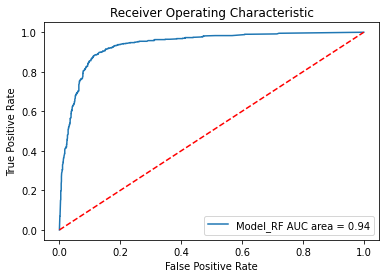

In [33]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel). 
For more information, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [34]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.82
Specificity: 0.92
AUC: 0.93


'/home/jovyan/Cheminformatics/results/roc_auc.png'

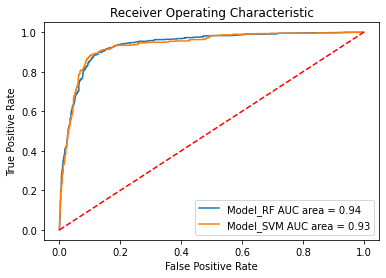

In [35]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons.

In [36]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.71
Specificity: 0.88
AUC: 0.89


'/home/jovyan/Cheminformatics/results/roc_auc.png'

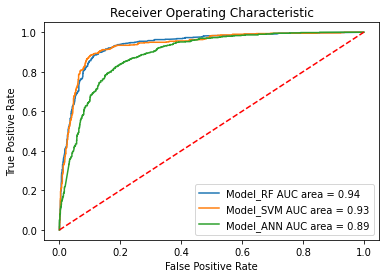

In [37]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

#### Cross-validation

In [38]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [39]:
N_FOLDS = 5

In [40]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.88 	and std : 0.01 
Mean sensitivity: 0.80 	and std : 0.02 
Mean specificity: 0.91 	and std : 0.01 
Mean AUC: 0.93 	and std : 0.01 
Time taken : 8.91s


Model_SVM
Mean accuracy: 0.89 	and std : 0.01 
Mean sensitivity: 0.80 	and std : 0.02 
Mean specificity: 0.92 	and std : 0.00 
Mean AUC: 0.92 	and std : 0.01 
Time taken : 216.11s


Model_ANN
Mean accuracy: 0.83 	and std : 0.01 
Mean sensitivity: 0.70 	and std : 0.03 
Mean specificity: 0.89 	and std : 0.01 
Mean AUC: 0.89 	and std : 0.01 
Time taken : 35.52s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [43]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [44]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL273264,6.54,N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,B,'=',290.00,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,CHEMBL116258,9.89,Cc1cnc(NCCc2ccccc2)c(=O)n1CC(=O)NCc1cc(Cl)ccc1CN,B,'=',0.13,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL408556,6.55,CC[C@@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](...,B,'=',280.00,1.0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [45]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.89 	and std : 0.00 
Mean sensitivity: 0.82 	and std : 0.02 
Mean specificity: 0.92 	and std : 0.00 
Mean AUC: 0.94 	and std : 0.01 
Time taken : 34.07s


Model_ANN
Mean accuracy: 0.87 	and std : 0.01 
Mean sensitivity: 0.80 	and std : 0.03 
Mean specificity: 0.90 	and std : 0.00 
Mean AUC: 0.93 	and std : 0.01 
Time taken : 313.13s



The next step is to see if we can also train a classification model. We will remove the censored data and train another model. 

In [46]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, make new data and run.

In [47]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 7812
Test data size: 1954


In [48]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.56 	and std : 0.01 
RMSE: 0.78 	and std : 0.01 



We use ONLY the RF model to run predictions on a new compound.

In [49]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare to its actual pChEMBL value)
# BELOW: ChEMBL top pIC50 molecules
test_smiles = [
    
    
    'C1=CC=C(C=C1)CC(C(=O)NCC(=O)NCC2=CC=C(C=C2)C(=N)N)NS(=O)(=O)CC3=CC=CC=C3',                    #UET
    
    'NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc1ccccc1)C(=O)O',                            ##CHEMBL275366 #1ST pIC50
    'CC(O)[C@@H](C(=O)N[C@H](C)c1ccccc1)N(C)C(=O)[C@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)CCCN=C(N)N',  ###CHEMBL105819#2ND
    'COc1cc(C(=O)N2CC(C)(CC(C)O)OC[C@H]2C)cc2nc(NC(CF)c3cccc(Cl)c3)oc12'                           ##CHEMBL4111930#4TH
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
C1=CC=C(C=C1)CC(C(=O)NCC(=O)NCC2=CC=C(C=C2)C(=N)N)NS(=O)(=O)CC3=CC=CC=C3,6.67
NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc1ccccc1)C(=O)O,7.84
CC(O)[C@@H](C(=O)N[C@H](C)c1ccccc1)N(C)C(=O)[C@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)CCCN=C(N)N,6.65
COc1cc(C(=O)N2CC(C)(CC(C)O)OC[C@H]2C)cc2nc(NC(CF)c3cccc(Cl)c3)oc12,9.49


In [50]:
# Designed molecules compared to control ligand UET
test_smiles = [
    
    
    'C1=CC=C(C=C1)CC(C(=O)NCC(=O)NCC2=CC=C(C=C2)C(=N)N)NS(=O)(=O)CC3=CC=CC=C3',       #UET
    'N=C(N)c2ccc(C[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC/N=C(N)/N)C(=O)O)cc2',      #PEP1
    'N/C(N)=N\CCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc2ccc(Cl)cc2)C(=O)O'          ##PEP2

]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
C1=CC=C(C=C1)CC(C(=O)NCC(=O)NCC2=CC=C(C=C2)C(=N)N)NS(=O)(=O)CC3=CC=CC=C3,6.67
N=C(N)c2ccc(C[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC/N=C(N)/N)C(=O)O)cc2,7.46
N/C(N)=N\CCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc2ccc(Cl)cc2)C(=O)O,7.82


## Lipinski Rule of 5 for the generated compounds

In [5]:
import math

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [6]:
#Manual import using SMILES
smiles = [
'NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc1ccccc1)C(=O)O', 'N=C(N)c2ccc(C[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC/N=C(N)/N)C(=O)O)cc2',' N/C(N)=N\CCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc2ccc(Cl)cc2)C(=O)O']
names = ["CHEMBL275366","PEP1", "PEP2"]

,name,smiles,ROMol
0,CHEMBL275366,NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,
1,PEP1,N=C(N)c2ccc(C[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@...,
2,PEP2,N/C(N)=N\CCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@...,

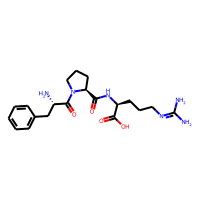
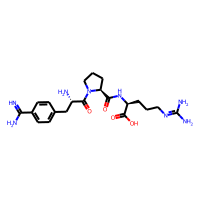
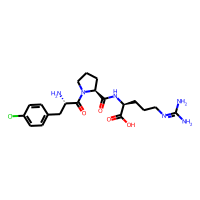

In [7]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

In [8]:
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# Colors are used for plotting the molecules later
molecules["color"] = ["red", "green", "blue"]
# NBVAL_CHECK_OUTPUT
molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]

,molecular_weight,n_hba,n_hbd,logp
0,418.232853,5,5,-0.82960
1,460.254652,6,7,-1.54553
2,452.193881,5,5,-0.17620


,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,color
0,CHEMBL275366,NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,,418.232853,5,5,-0.82960,red
1,PEP1,N=C(N)c2ccc(C[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@...,,460.254652,6,7,-1.54553,green
2,PEP2,N/C(N)=N\CCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@...,,452.193881,5,5,-0.17620,blue

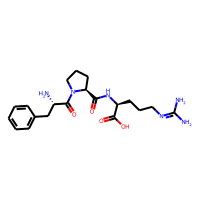
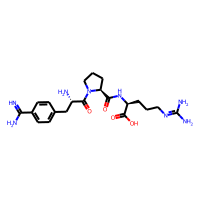
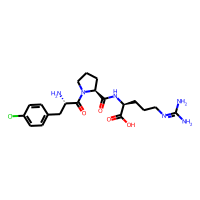

In [9]:
# Full preview
molecules

In [10]:
#To plot the molecule properties
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

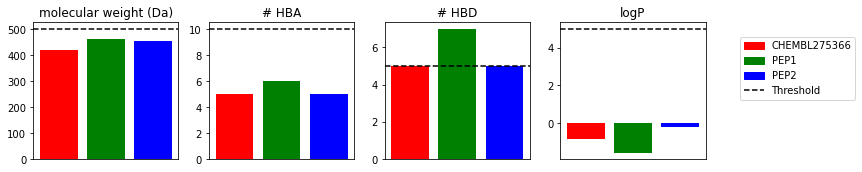

In [11]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1,2,3], molecules[key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

### Investigate compliance with Ro5

In [12]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [13]:
# NBVAL_CHECK_OUTPUT
for name, smiles in zip(molecules["name"], molecules["smiles"]):
    print(f"Ro5 fulfilled for {name}: {calculate_ro5_properties(smiles)['ro5_fulfilled']}")

Ro5 fulfilled for CHEMBL275366: True
Ro5 fulfilled for PEP1: True
Ro5 fulfilled for PEP2: True
